# Tutorial: Add additional effects to simulated radial velocities

By default, radial velocities (RVs) simulated from Phitter's model binaries have zero center of mass RV. Currently Phitter allows adding a constant offset. More complex offsets to the center of mass (such as motion of the binary in a wider orbit) are planned for the future.

## Imports

In [1]:
from phitter import observables, filters
from phitter.params import star_params, binary_params, isoc_interp_params
from phitter.calc import model_obs_calc, phot_adj_calc, rv_adj_calc

import numpy as np

from phoebe import u
from phoebe import c as const
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# The following warning regarding extinction originates from SPISEA and can be ignored.
# The functionality being warned about is not used by SPISEA.

/Users/abhimat/Software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Volumes/Noh/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up model binary

Let's build off the same red giant binary system we simulated in the [previous tutorial](add_phot_effects).

In [2]:
filter_153m = filters.hst_f153m_filt()
filter_127m = filters.hst_f127m_filt()

In [3]:
# Object for interpolating stellar parameters from an isochrone

isoc_stellar_params_obj = isoc_interp_params.isoc_mist_stellar_params(
    age=8e9,
    met=0.0,
    use_atm_func='merged',
    phase='RGB',
    ext_Ks=2.2,
    dist=8e3*u.pc,
    filts_list=[filter_153m, filter_127m],
    ext_law='NL18',
)

In [4]:
star1_params = isoc_stellar_params_obj.interp_star_params_rad(
    15,
)

print("Star 1 Parameters")
print(star1_params)

star2_params = isoc_stellar_params_obj.interp_star_params_rad(
    12,
)

print("Star 2 Parameters")
print(star2_params)

Star 1 Parameters
mass_init = 1.103 solMass
mass = 1.100 solMass
rad = 15.000 solRad
lum = 70.325 solLum
teff = 4315.7 K
logg = 2.127
syncpar = 1.000
---
filt <phitter.filters.hst_f153m_filt object at 0x104e79880>:
mag = 17.457
mag_abs = -1.909
pblum = 0.975 solLum
filt <phitter.filters.hst_f127m_filt object at 0x104e79e20>:
mag = 20.483
mag_abs = -1.431
pblum = 1.181 solLum

Star 2 Parameters
mass_init = 1.102 solMass
mass = 1.100 solMass
rad = 12.000 solRad
lum = 49.434 solLum
teff = 4418.1 K
logg = 2.321
syncpar = 1.000
---
filt <phitter.filters.hst_f153m_filt object at 0x104e79880>:
mag = 17.883
mag_abs = -1.483
pblum = 0.659 solLum
filt <phitter.filters.hst_f127m_filt object at 0x104e79e20>:
mag = 20.887
mag_abs = -1.028
pblum = 0.815 solLum



In [5]:
# Binary parameters
bin_params = binary_params.binary_params(
    period = 30.0 * u.d,
    ecc = 0.2,
    inc = 80.0 * u.deg,
    t0 = 53_800.0,
)

In [6]:
# Set up model times
# Model times are in MJD here
model_phases = np.linspace(0, 1, num=100)
model_times = model_phases * bin_params.period.value + bin_params.t0

In [7]:
# Set up filter and observation type arrays for the model fluxes and RVs

flux_153m_filt_arr = np.full(len(model_phases), filter_153m)
flux_153m_type_arr = np.full(len(model_phases), 'phot')

flux_127m_filt_arr = np.full(len(model_phases), filter_127m)
flux_127m_type_arr = np.full(len(model_phases), 'phot')

rv_pri_filt_arr = np.full(len(model_phases), filter_153m)
rv_pri_type_arr = np.full(len(model_phases), 'rv_pri')

rv_sec_filt_arr = np.full(len(model_phases), filter_153m)
rv_sec_type_arr = np.full(len(model_phases), 'rv_sec')

In [8]:
# Now make arrays for all the times, filters, and observation types by concatenating the above arrays

obs_times = np.concatenate(
    (model_times, model_times, model_times, model_times),
)
obs_filts = np.concatenate(
    (flux_153m_filt_arr, flux_127m_filt_arr, rv_pri_filt_arr, rv_sec_filt_arr,),
)
obs_types = np.concatenate(
    (flux_153m_type_arr, flux_127m_type_arr, rv_pri_type_arr, rv_sec_type_arr,),
)

In [9]:
# Finally, construct the observables object

model_observables = observables.observables(
    obs_times=obs_times,
    obs_filts=obs_filts, obs_types=obs_types,
)

In [10]:
# Object to perform the computation of flux and RVs

binary_model_obj = model_obs_calc.binary_star_model_obs(
    model_observables,
    use_blackbody_atm=False,
    print_diagnostics=False,
)

In [11]:
modeled_observables = binary_model_obj.compute_obs(
    star1_params, star2_params, bin_params,
)

In [12]:
# Fluxes in mags
modeled_mags_153m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_153m]]
modeled_mags_127m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_127m]]

# RVs in km/s
modeled_rvs_star1 = modeled_observables.obs[modeled_observables.obs_rv_pri_filter]
modeled_rvs_star2 = modeled_observables.obs[modeled_observables.obs_rv_sec_filter]


In [13]:
# Add distance modulus

modeled_observables = phot_adj_calc.apply_distance_modulus(
    modeled_observables,
    8e3*u.pc,
)

In [14]:
# Apply reddening from extinction

modeled_observables = phot_adj_calc.apply_extinction(
    modeled_observables,
    isoc_Ks_ext=2.2,
    ref_filt=filter_153m,
    target_ref_filt_ext=4.5,
    isoc_red_law='NL18',
    ext_alpha=2.23,
)

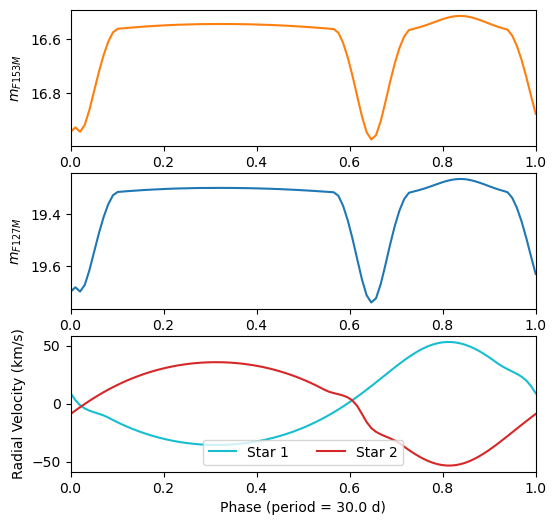

In [15]:
# Fluxes in mags
modeled_mags_153m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_153m]]
modeled_mags_127m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_127m]]

# RVs in km/s
modeled_rvs_star1 = modeled_observables.obs[modeled_observables.obs_rv_pri_filter]
modeled_rvs_star2 = modeled_observables.obs[modeled_observables.obs_rv_sec_filter]

# Draw plot
fig = plt.figure(figsize=(6,6))

# F153M mags subplot
ax_mag_153m = fig.add_subplot(3,1,1)

ax_mag_153m.plot(
    model_phases, modeled_mags_153m,
    '-', color='C1',
)

ax_mag_153m.set_xlim([0, 1])

ax_mag_153m.invert_yaxis()
ax_mag_153m.set_ylabel(r"$m_{F153M}$")

# F153M mags subplot
ax_mag_127m = fig.add_subplot(3,1,2)

ax_mag_127m.plot(
    model_phases, modeled_mags_127m,
    '-', color='C0',
)

ax_mag_127m.set_xlim([0, 1])

ax_mag_127m.invert_yaxis()
ax_mag_127m.set_ylabel(r"$m_{F127M}$")

# RVs subplot
ax_rvs = fig.add_subplot(3,1,3)

ax_rvs.plot(
    model_phases, modeled_rvs_star1,
    '-', color='C9', label='Star 1',
)

ax_rvs.plot(
    model_phases, modeled_rvs_star2,
    '-', color='C3', label='Star 2',
)

ax_rvs.set_xlabel(f"Phase (period = {bin_params.period:.1f})")
ax_rvs.set_xlim([0, 1])

ax_rvs.set_ylabel("Radial Velocity (km/s)")

ax_rvs.legend(loc='lower center', ncol=2)


# Add a constant offset for the center of mass RV

In [16]:
# Apply reddening from extinction

modeled_observables = rv_adj_calc.apply_com_velocity(
    modeled_observables,
    150. * u.km / u.s,
)

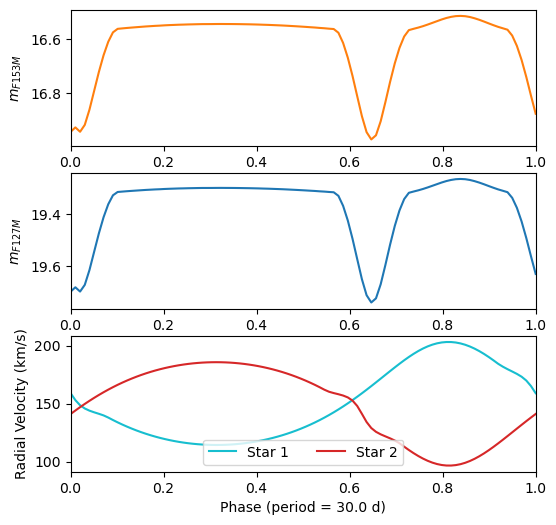

In [17]:
# Fluxes in mags
modeled_mags_153m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_153m]]
modeled_mags_127m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_127m]]

# RVs in km/s
modeled_rvs_star1 = modeled_observables.obs[modeled_observables.obs_rv_pri_filter]
modeled_rvs_star2 = modeled_observables.obs[modeled_observables.obs_rv_sec_filter]

# Draw plot
fig = plt.figure(figsize=(6,6))

# F153M mags subplot
ax_mag_153m = fig.add_subplot(3,1,1)

ax_mag_153m.plot(
    model_phases, modeled_mags_153m,
    '-', color='C1',
)

ax_mag_153m.set_xlim([0, 1])

ax_mag_153m.invert_yaxis()
ax_mag_153m.set_ylabel(r"$m_{F153M}$")

# F153M mags subplot
ax_mag_127m = fig.add_subplot(3,1,2)

ax_mag_127m.plot(
    model_phases, modeled_mags_127m,
    '-', color='C0',
)

ax_mag_127m.set_xlim([0, 1])

ax_mag_127m.invert_yaxis()
ax_mag_127m.set_ylabel(r"$m_{F127M}$")

# RVs subplot
ax_rvs = fig.add_subplot(3,1,3)

ax_rvs.plot(
    model_phases, modeled_rvs_star1,
    '-', color='C9', label='Star 1',
)

ax_rvs.plot(
    model_phases, modeled_rvs_star2,
    '-', color='C3', label='Star 2',
)

ax_rvs.set_xlabel(f"Phase (period = {bin_params.period:.1f})")
ax_rvs.set_xlim([0, 1])

ax_rvs.set_ylabel("Radial Velocity (km/s)")

ax_rvs.legend(loc='lower center', ncol=2)
